<a href="https://colab.research.google.com/github/mibarguen/recommendations-at-scale/blob/main/notebooks/week2_multiTask_Bandit_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Welcome to week 2 project!**

Congratulations on making it to week 2! 👏 In the first week of this course, we covered the basics of how to design personalized recommendation systems. We then provided some system design examples for large scale recommenders from corporations like Spotify and YouTube, as well as techniques for candidate generation, specifically the two-tower model being used at Twitter and Pinterest.

This week, we covered details of ML approaches for recommendations: including multi-task recommenders and contextual bandits.

In this week's project, we will touch upon both these methods at a high level. We first begin by developing a simple multi-task model, and then cover a contextual bandit model. For ease of use, we will re-use our H&M dataset from week 1 for Multi-task model, and will switch to using Yahoo! news dataset for contextual bandit model.


# **Multi-task Recommendations**

Multi-task recommenders provide a way to predict multiple facets of user engagement in order to make comprehensive recommendations for content that users might like.



In [1]:
from IPython.core.display import Image, display
display(Image(url='https://miro.medium.com/max/3688/1*rrIJOpJO8fkFECNHlwq-jQ.png', width=500, unconfined=True))


**Single task recommender:** we will start by deveoping a single task model that makes predictions about whether the user will purchase the article or not.

**Multi-task recommender:** we then expand the scope to consider auxilliary prediction tasks, in order to improve the recommendation performance.

Specifically, we make the folliwing three predictions using a multi-task setup:
1. Predicting whether the user will make any purchase next week or not
2. Predicting which category the user will make purchase in
3. Predicting which specific item the user will buy

We will use different loss functions to jointly train the multi-task network.

**Negative Sampling**
It is important to note that the dataset is only of positive cases -- cases wherein the user bought an article. To train our models, we will have to resort to negative sampling to develop a mixed dataset comprising of positive and negative examples.

We will cover two categories of negative sampling:
1. Random negative sampling
2. Negative sampling with bias

**Evaluation:**
We will evaluate the ranker performance on various ranking metrics.


In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
from typing import Dict, Text
from functools import reduce
import os
import pprint
import tempfile
from typing import Dict, Text
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from tensorflow import feature_column
import random

In [75]:
article_df = pd.read_csv("../data/hmdata/articles.csv")
customer_df = pd.read_csv("../data/hmdata/customers.csv")
train0 = pd.read_csv('../data/hmdata/transactions_train.csv')
transaction_df = train0

# **Simple Feature Processing**

In this section we focus on extracting features for trainnig the ranking models. We focus primarily on extracting user features, and article features, and leave sophisticated feature modelin for next week.

For users specifically, we will focus on extracting the following features:
1. age bucket
2. no of past purchases
3. min/max/avg price
4. distrbution over product group
5. distrbution over section

For aticles, we will learn embedding based features for the article category, product group, and department.


In [76]:
unique_customer_ids = customer_df.customer_id.unique()
unique_article_ids = article_df.article_id.unique()

In [77]:
subset = train0[train0["t_dat"] > "2020-06-01"]
print(len(train0),len(subset))

31788324 5108386


In [78]:
subset['train'] = (subset['t_dat'] < '2020-08-22').astype(int)

<ipython-input-78-e73aba4db828>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['train'] = (subset['t_dat'] < '2020-08-22').astype(int)


In [79]:
joined = pd.merge(subset, article_df, on='article_id', how='outer')

In [80]:
f1 = joined.groupby("customer_id", as_index=False).article_id.nunique() #unique articles
f2 = joined.groupby("customer_id", as_index=False).t_dat.nunique() #days active
f3 = joined.groupby("customer_id", as_index=False).size() #total purchases
f4 = joined.groupby("customer_id", as_index=False).price.min() #min price
f5 = joined.groupby("customer_id", as_index=False).price.max() #max price
f6 = joined.groupby("customer_id", as_index=False).price.mean() #mean price
f7 = joined.groupby("customer_id", as_index=False).product_group_name.nunique() #num unique product groups
f8 = joined.groupby("customer_id", as_index=False).department_name.nunique() #num unique department_name
f9 = joined.groupby("customer_id", as_index=False).section_name.nunique() #num unique section_name

In [81]:
data_frames = [f1,f2,f3,f4,f5,f6,f7,f8,f9]
fAll = reduce(lambda  left,right: pd.merge(left,right,on=['customer_id'],
                                            how='outer'), data_frames)

fAll.columns = ['customer_id', 'nArticles', 'nDays',
                'nPurchases', 'minPrice', 'maxPrice',
                'meanPrice', 'nPGroups', 'nDept', 'nSect'
               ]


In [82]:
joinedF = pd.merge(joined, fAll, on='customer_id', how='outer')

In [83]:
print(list(joinedF))

['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id', 'train', 'product_code', 'prod_name', 'product_type_no', 'product_type_name', 'product_group_name', 'graphical_appearance_no', 'graphical_appearance_name', 'colour_group_code', 'colour_group_name', 'perceived_colour_value_id', 'perceived_colour_value_name', 'perceived_colour_master_id', 'perceived_colour_master_name', 'department_no', 'department_name', 'index_code', 'index_name', 'index_group_no', 'index_group_name', 'section_no', 'section_name', 'garment_group_no', 'garment_group_name', 'detail_desc', 'nArticles', 'nDays', 'nPurchases', 'minPrice', 'maxPrice', 'meanPrice', 'nPGroups', 'nDept', 'nSect']


In [69]:
pd.set_option('display.max_column', None)

In [146]:
columns = ['customer_id','article_id',
           'price',
          'product_group_name', 'department_name',
             'section_name',
             'nArticles',
             'nDays',
             'nPurchases',
             'minPrice',
             'maxPrice',
             'meanPrice',
             'nPGroups',
             'nDept',
             'nSect']

trainF = joinedF[(~joinedF["customer_id"].isna())][columns]


# Negative Sampling for training ranker

If you notice the dataset, we only have purchase information. This is generallyt he case -- we often only observe positive interactions from users. However, to train a model, we would need access to positive and negative samples both.

To generate negative sampled, here we focus on random sampling of negative examples per user-artice transaction. Other methods exist to sample negatives, namely:
1. Random sampling
2. Biased sampling from similar categories
3. Cross-batch negative sampling

In this project, we will go ahead with the random sampling strategy.

In [147]:
tt = trainF.groupby("customer_id", as_index=False).article_id.agg(['unique']).reset_index()
tt.columns = ['customer_id', 'article_list']

In [148]:
tt.head()

,customer_id,article_list
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,[568601043]
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,[826211002]
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[794321007]
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[827971001, 589440005, 818320001, 730683050, 9..."
4,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,"[448509014, 719530003]"


In [149]:
articlesSet = list(trainF.article_id.unique())

In [150]:
print(len(articlesSet))
tt.columns = ['customer_id', 'article_list']
print(list(tt))

45892
['customer_id', 'article_list']


In [155]:
def generate_negative_samples(train_df, article_list, num_neg=1):
    negData = []
    for index, row in train_df.iterrows():
        allList = article_list
        cust = row['customer_id']
        art_list = row['article_list']
        allList = list(set(allList) - set(art_list))
        negs = random.sample(allList, num_neg)
        for n in negs:
            negData.append([cust,n])
    negDf = pd.DataFrame(negData,columns=['customer_id','article_id'])
    return negDf

In [158]:
negDf = generate_negative_samples(tt.head(40000),articlesSet,2)
negDf

,customer_id,article_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,894687002
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,862970002
2,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,746073003
3,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,930829001
4,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,949551002
...,...,...
79995,11297a0414218c18ab7109376c63c7d8f093b49bbd254d...,805921001
79996,1129a321da62de7224393a06c477b851d0581636f7b9e7...,528344007
79997,1129a321da62de7224393a06c477b851d0581636f7b9e7...,866958002
79998,112a04b065c314ab86a3536a3d31c267f88200435cbe75...,581363010


### We next generate features for negatives

In [159]:
joinedFN = pd.merge(negDf, article_df[['article_id','product_group_name',
                                       'department_name','section_name']],
                    on='article_id', how='left'
                   )

joinedFN = pd.merge(joinedFN, fAll, on='customer_id', how='left')
joinedFN.sample(20)

,customer_id,article_id,product_group_name,department_name,section_name,nArticles,nDays,nPurchases,minPrice,maxPrice,meanPrice,nPGroups,nDept,nSect
19717,04324e01acafd9f8dfd84350cd17b2b3fd37e13643ba13...,729006001,Accessories,Belts,Womens Big accessories,16,4,21,0.013542,0.050831,0.025487,4,7,5
52579,0b3ce5076ec53290b018089e0d190bdc053a9a97d26804...,705799005,Shoes,Premium Quality,Womens Shoes,1,1,1,0.033881,0.033881,0.033881,1,1,1
30941,0695dad356c94dae890dfd7866066335b1391857e25083...,835576001,Accessories,Small Accessories,Men Accessories,7,4,7,0.011508,0.035576,0.019971,3,5,5
62037,0d4f0adf86ae7b25b72ffb5c49709f8b973c20e6efc231...,807793001,Garment Full body,Trousers & Skirt,Womens Trend,4,1,4,0.011847,0.038119,0.023076,3,4,3
3931,00dc9191f7c9fa1e2a43980e55f72280bcb7c983a5d9cd...,756322001,Nightwear,Nightwear,"Womens Nightwear, Socks & Tigh",2,1,2,0.005068,0.022864,0.013966,2,2,2
39539,08741cd5434c1d2dd49784c72c9ac9b2903f6808e0f233...,717811002,Garment Full body,Dress,Womens Tailoring,3,2,3,0.008458,0.019051,0.012554,2,3,3
45649,09bae3499d480dfd265885a0cf6df1f84f6f9baa99f8db...,815446023,Accessories,Baby Toys/Acc,Baby Essentials & Complements,5,2,5,0.002695,0.033881,0.017339,3,4,4
79360,1107067ec2cf606cf36560f59cd08b59752f4b12113a23...,837804003,Swimwear,Kids Girl Swimwear,"Kids Accessories, Swimwear & D",17,2,17,0.009356,0.033051,0.020410,5,8,5
43176,09365d9f8408c160e188ac70141c21e13908c6f2c25701...,874622001,Garment Upper body,License,Young Girl,1,1,1,0.016932,0.016932,0.016932,1,1,1
53386,0b66e3c37ffaca5aad2d9570c6d3513e811162fba7f762...,753866003,Garment Upper body,Young Girl Jersey Basic,Girls Underwear & Basics,4,1,4,0.016932,0.025407,0.021169,1,1,1


In [160]:
trainF['label1']=1
joinedFN['label1']=0

In [161]:
data = [trainF.head(40000), joinedFN]
trainDF = pd.concat(data)

In [162]:
trainDF.sample(10)

,customer_id,article_id,price,product_group_name,department_name,section_name,nArticles,nDays,nPurchases,minPrice,maxPrice,meanPrice,nPGroups,nDept,nSect,label1
5381,369766c07cd81b27de105ddf29c48557ff0c34896de38c...,832453006,0.016203,Garment Upper body,Jersey fancy,Womens Everyday Collection,26.0,8.0,31.0,0.001678,0.040492,0.013521,8.0,16.0,13.0,1
48223,0a4f2646052952a9cf234591793782c9bde958d6db9a15...,830273001,NaN,Garment Upper body,Shirt,Contemporary Casual,9.0,1.0,9.0,0.004068,0.050831,0.022584,5.0,6.0,4.0,0
33540,07226b1385a9747872b183c58d9008df269a05ac8afdcb...,901333001,NaN,Garment Full body,Knitwear,Womens Trend,2.0,1.0,3.0,0.008458,0.011847,0.009588,1.0,2.0,2.0,0
32957,07038c902109b8d937c3d559593592dd40b2d8d046b6f8...,379360033,NaN,Garment Lower body,Kids Girl Jersey Basic,Girls Underwear & Basics,5.0,1.0,5.0,0.008458,0.013542,0.011169,3.0,4.0,4.0,0
407,f96661e9e56449885d4c4b90d3227e4abea5e0d2382e2d...,850641002,0.021169,Garment Full body,Dresses,Divided Collection,84.0,26.0,107.0,0.001356,0.042356,0.012314,6.0,29.0,14.0,1
25596,9605a2cf7eabdb4a3a3ee98e5c93e24c67b6fe35f7aa27...,554450046,0.033881,Garment Lower body,Trousers,Divided Collection,61.0,19.0,80.0,0.001678,0.042356,0.020910,7.0,21.0,10.0,1
3933,deb91d375d06b83247cd1cea995914b298e951fe702473...,752814016,0.033881,Garment Lower body,Trouser,Womens Everyday Collection,35.0,6.0,45.0,0.007610,0.061000,0.019409,3.0,15.0,10.0,1
31593,06b887550cf817ca9b362155325302bdd164a2007d399d...,823791013,NaN,Garment Upper body,Suit,Womens Tailoring,13.0,3.0,15.0,0.008458,0.050831,0.020887,3.0,7.0,5.0,0
45532,09b4c7a79732edaecf26d84b6e7563bb7c815c14741227...,841383003,NaN,Garment Upper body,Jersey Basic,Womens Everyday Basics,3.0,2.0,3.0,0.008458,0.033881,0.022582,3.0,3.0,3.0,0
37952,9bc570c632548161176215ceb6e8c0181ae5399a1ed30e...,918717001,0.048695,Garment Full body,Trouser,Womens Everyday Collection,39.0,10.0,47.0,0.006085,0.083220,0.034732,6.0,16.0,10.0,1


In [163]:
trainDF.to_pickle("../data/trainDF.pkl")

In [164]:
print(list(trainDF))

['customer_id', 'article_id', 'price', 'product_group_name', 'department_name', 'section_name', 'nArticles', 'nDays', 'nPurchases', 'minPrice', 'maxPrice', 'meanPrice', 'nPGroups', 'nDept', 'nSect', 'label1']


## Single Task Ranker

We begin by training a single task ranker for the task of predicting whether the user will purchase a given article or not.

In [192]:

numFeatures = ['nArticles','nDays','nPurchases','minPrice','maxPrice','meanPrice','nPGroups','nDept','nSect']
catFeatures = ['product_group_name']
X1 = np.asarray(trainDF[numFeatures].values)
X2 = np.asarray(trainDF[catFeatures].values)

X2 = np.asarray(trainDF[catFeatures].values)
y1 = np.asarray(trainDF['label1'].values)

inp1 = tf.keras.Input((len(numFeatures)))
#inp2 = tf.keras.Input((len(catFeatures)),dtype='str')
#inp2 = tf.keras.Input((len(catFeatures)))

unique_article_ids = article_df.article_id.unique().astype(str)


x1 = tf.keras.layers.Dense(32, activation='relu')(inp1)
embedding_dimension=50
#xx2 = tf.keras.layers.StringLookup(vocabulary=unique_article_ids, mask_token=None)(inp2)
#xx2 = tf.keras.layers.Embedding(len(unique_article_ids) + 1, embedding_dimension)(xx2)
#xx2 = tf.keras.layers.Flatten()(xx2)
#x2 = tf.keras.layers.Dense(32, activation='relu')(xx2)

#x12 = tf.keras.layers.concatenate([x1,x2])
#out1 = tf.keras.layers.Dense(1, activation='sigmoid')(x12)
out1 = tf.keras.layers.Dense(1, activation='sigmoid')(x1)
#out2 = tf.keras.layers.Dense(2, activation='softmax')(x123)
#m = tf.keras.Model([inp,inp2,inp3], [out1,out2])
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metric = tf.keras.metrics.BinaryAccuracy()
m = tf.keras.Model([inp1], out1)
m.compile(loss=bce,
          optimizer='adam',
          metrics=[metric])

m.fit([X1], [y1], epochs=10, verbose=1,batch_size=1000)

#m.evaluate([X1,X2], [y1])

Epoch 1/10
120/120 [==============================] - 0s 1ms/step - loss: 0.8473 - binary_accuracy: 0.5877
Epoch 2/10
120/120 [==============================] - 0s 2ms/step - loss: 0.5054 - binary_accuracy: 0.8031
Epoch 3/10
120/120 [==============================] - 0s 1ms/step - loss: 0.4550 - binary_accuracy: 0.8127
Epoch 4/10
120/120 [==============================] - 0s 2ms/step - loss: 0.4303 - binary_accuracy: 0.8166
Epoch 5/10
120/120 [==============================] - 0s 2ms/step - loss: 0.4160 - binary_accuracy: 0.8203
Epoch 6/10
120/120 [==============================] - 0s 1ms/step - loss: 0.4066 - binary_accuracy: 0.8244
Epoch 7/10
120/120 [==============================] - 0s 1ms/step - loss: 0.4000 - binary_accuracy: 0.8266
Epoch 8/10
120/120 [==============================] - 0s 1ms/step - loss: 0.3953 - binary_accuracy: 0.8266
Epoch 9/10
120/120 [==============================] - 0s 1ms/step - loss: 0.3916 - binary_accuracy: 0.8264
Epoch 10/10
120/120 [================

In [193]:
m.evaluate([X1], [y1])

3750/3750 [==============================] - 3s 839us/step - loss: 0.3882 - binary_accuracy: 0.8239


[0.38818612694740295, 0.8238666653633118]

In [194]:
m.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 9)]               0         
                                                                 
 dense_27 (Dense)            (None, 32)                320       
                                                                 
 dense_28 (Dense)            (None, 1)                 33        
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


### **From single to multi-task recommendation model**
We can now add another task to enrich the single task model to multi-task model. To do so, we first have to decide what the task 2 would be.

By looking at the data we have, we hypothesize that being able to predict whether or not a customer would purchase an article from certain product category would be a good learnt model to have. Indeed, being able to predict which category would the user purchase in would help us narrow down the list of recommendations we want to surface infront of users.

Based on this intuition, we want to develop a multi-task model with 2 tasks:
1. Task 1: predict whether or not a user would purchase an article
2. Task 2: predict whether or not a user would purchase any article from a given category

The training data we have created thus far is solely based on prediction task 1: predicting whether or not a user would purchase a given article. Corredpondingly, in trainDF dataframe we have collected positive and nagetive examples for this task, and have added a label1 column as the final label to train the model.

To develop a multi-task model for these two tasks, we will now need to add a label for the second task in the same dataset: trainDF. To do so, we will need to add a column: label2 to this dataframe -- for each row, we will need to identify whether the user has made any purchase in this category or not, and if the user has made a purchase in this category, then we will assign label2 = 1, else label2 = 0. Please note that for the same training example, it may happen that label1 = 0 but label2 = 1; this would happen in cases wherein the customer did not purchase this specific article but did purchase any other article from this category.

The goal for this project is to write the function that adds this label2 column to the trainDF dataframe, to enable us to train a multi-task model.

In [170]:
trainDF['label1'].value_counts()

0    80000
1    40000
Name: label1, dtype: int64

In [171]:
def add_label2_to_trainDF():
    """
    write code here to add a new column to trainDF
    the new column would be named label2 and it represents the label for the task 2
    
    After this function has been run, it can be safely assumed that trainDF dataframe contains another column called "label2"
    that describes the label for the second prediction task.
    """
    product_category_col = 'section_name'
    product_category_user_dict = {}

    for product_category in trainDF[product_category_col].unique():
        product_users = trainDF[(trainDF[product_category_col] == product_category) &
                                (trainDF['label1'] == 1)
                               ]['customer_id'].unique().tolist()
        product_category_user_dict[product_category] = product_users

    trainDF['label2'] = trainDF.apply(lambda x: int(x['customer_id'] in product_category_user_dict[x[product_category_col]]),
                                    axis=1)



In [172]:
add_label2_to_trainDF()

In [182]:
trainDF['label2'].value_counts()

0    79918
1    40082
Name: label2, dtype: int64

Now that we have both the label1 and label2 in our dataset, we can construct a simple multi-task model with shared bottom, which we call the common layers. Building on top of the common layers, we will have two separate modules: task1 layers and task2 layers. Layers of task 1 ("task1a" and "task1b") are dedicated to learning weights that help us perform better on task1. Correspondingly, layers of task 2 ("task2a" and "task2b") are dedicated to learning weights that help us perform better on task2.

Below we implement such a multi-task model.

In [187]:
embedding_dimension=50

numFeatures = ['nArticles','nDays','nPurchases','minPrice','maxPrice','meanPrice','nPGroups','nDept','nSect']
catFeatures = ['product_group_name']
X1 = np.asarray(trainDF[numFeatures].values)
y1 = np.asarray(trainDF['label1'].values)
y2 = np.asarray(trainDF['label2'].values) # replace label1 by label2 here

inp1 = tf.keras.Input((len(numFeatures)))

unique_article_ids = article_df.article_id.unique().astype(str)


common = tf.keras.layers.Dense(128, activation='relu',name="common1")(inp1)
common = tf.keras.layers.Dense(64, activation='relu',name="common2")(common)

x1 = tf.keras.layers.Dense(32, activation='relu',name="task1a")(common)
x1 = tf.keras.layers.Dense(16, activation='relu',name="task1b")(x1)
out1 = tf.keras.layers.Dense(1, activation='sigmoid',name="out1")(x1)

x2 = tf.keras.layers.Dense(32, activation='relu',name="task2a")(common)
x2 = tf.keras.layers.Dense(16, activation='relu',name="task2b")(x2)
out2 = tf.keras.layers.Dense(1, activation='sigmoid',name="out2")(x2)


bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metric = tf.keras.metrics.BinaryAccuracy()
m2 = tf.keras.Model([inp1], [out1,out2])
m2.compile(loss=bce,
          optimizer='adam',
          metrics=[metric])

m2.fit([X1], [y1,y2], epochs=10, verbose=1,batch_size=1000)

#m.evaluate([X1,X2], [y1])

Epoch 1/10
120/120 [==============================] - 1s 3ms/step - loss: 0.9885 - out1_loss: 0.4804 - out2_loss: 0.5081 - out1_binary_accuracy: 0.7988 - out2_binary_accuracy: 0.7853
Epoch 2/10
120/120 [==============================] - 0s 3ms/step - loss: 0.7818 - out1_loss: 0.3901 - out2_loss: 0.3917 - out1_binary_accuracy: 0.8230 - out2_binary_accuracy: 0.8241
Epoch 3/10
120/120 [==============================] - 0s 3ms/step - loss: 0.7609 - out1_loss: 0.3808 - out2_loss: 0.3800 - out1_binary_accuracy: 0.8245 - out2_binary_accuracy: 0.8263
Epoch 4/10
120/120 [==============================] - 0s 3ms/step - loss: 0.7544 - out1_loss: 0.3773 - out2_loss: 0.3771 - out1_binary_accuracy: 0.8267 - out2_binary_accuracy: 0.8278
Epoch 5/10
120/120 [==============================] - 0s 3ms/step - loss: 0.7546 - out1_loss: 0.3776 - out2_loss: 0.3770 - out1_binary_accuracy: 0.8265 - out2_binary_accuracy: 0.8273
Epoch 6/10
120/120 [==============================] - 0s 3ms/step - loss: 0.7527 - ou

In [188]:
m2.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 common1 (Dense)                (None, 128)          1280        ['input_20[0][0]']               
                                                                                                  
 common2 (Dense)                (None, 64)           8256        ['common1[0][0]']                
                                                                                                  
 task1a (Dense)                 (None, 32)           2080        ['common2[0][0]']                
                                                                                           

In [201]:
m2.evaluate([X1], [y1, y2])

3750/3750 [==============================] - 4s 1ms/step - loss: 0.7363 - out1_loss: 0.3680 - out2_loss: 0.3683 - out1_binary_accuracy: 0.8325 - out2_binary_accuracy: 0.8335


[0.7362822890281677,
 0.3679778575897217,
 0.36830416321754456,
 0.8324916958808899,
 0.8335166573524475]

### Checkpoint & goals
By now you should have implemented the function **def add_label2_to_trainDF()** and replaced label1 in the above code by label2 and trained the multi-task model with these 2 tasks.

Please record the performance of both the single task model and multi-task model and provide your interpretation of the results

> Performance Single Task Model: 0.82 Accuracy
> Performance Multi Task Model: 0.83 Accuracy

We see a slight improvement on the Multi-Task model over the single task model. However, this improvement is too small and it might be due to random error. 

## Freezing layers for secondary tasks

Often when training a multi-task model, one needs to freeze parts of the nueral network and only train one specific task module, while keeping the weights of the other task module fixed. In Keras we can do this by freezing layers. The below example demonstrates how one could go about freezing layers in a neural network, and train only the trainable parts of a nueral network.

In [202]:
# lets print the training status of each layer of the models we have
for k,v in m2._get_trainable_state().items():
    print(k,v)

<keras.engine.functional.Functional object at 0x7f7ac2419040> True
<keras.engine.input_layer.InputLayer object at 0x7f7ac3378760> True
<keras.layers.core.dense.Dense object at 0x7f7ac494cc40> True
<keras.layers.core.dense.Dense object at 0x7f7ac24271c0> True
<keras.layers.core.dense.Dense object at 0x7f7ac3e20640> True
<keras.layers.core.dense.Dense object at 0x7f7ac2427250> False
<keras.layers.core.dense.Dense object at 0x7f7ac23fa100> True
<keras.layers.core.dense.Dense object at 0x7f7ac494ad00> False
<keras.layers.core.dense.Dense object at 0x7f7ac493cb50> True
<keras.layers.core.dense.Dense object at 0x7f7ac494af10> True


In [203]:
# Lets try to freeze layers for task 2 so that no training example affects the module dedicated to task 2
for layer in m2.layers:
    if layer.name in ["task2a","task2b"]:
        layer.trainable = False

In [204]:
for k,v in m2._get_trainable_state().items():
    print(k,v)

<keras.engine.functional.Functional object at 0x7f7ac2419040> True
<keras.engine.input_layer.InputLayer object at 0x7f7ac3378760> True
<keras.layers.core.dense.Dense object at 0x7f7ac494cc40> True
<keras.layers.core.dense.Dense object at 0x7f7ac24271c0> True
<keras.layers.core.dense.Dense object at 0x7f7ac3e20640> True
<keras.layers.core.dense.Dense object at 0x7f7ac2427250> False
<keras.layers.core.dense.Dense object at 0x7f7ac23fa100> True
<keras.layers.core.dense.Dense object at 0x7f7ac494ad00> False
<keras.layers.core.dense.Dense object at 0x7f7ac493cb50> True
<keras.layers.core.dense.Dense object at 0x7f7ac494af10> True


In [205]:
m2.compile(loss=bce,
          optimizer='adam',
          metrics=[metric])

m2.fit([X1], [y1,y2], epochs=10, verbose=1,batch_size=1000)

Epoch 1/10
120/120 [==============================] - 1s 4ms/step - loss: 0.7397 - out1_loss: 0.3700 - out2_loss: 0.3696 - out1_binary_accuracy: 0.8303 - out2_binary_accuracy: 0.8313
Epoch 2/10
120/120 [==============================] - 0s 3ms/step - loss: 0.7378 - out1_loss: 0.3689 - out2_loss: 0.3688 - out1_binary_accuracy: 0.8313 - out2_binary_accuracy: 0.8323
Epoch 3/10
120/120 [==============================] - 0s 3ms/step - loss: 0.7378 - out1_loss: 0.3690 - out2_loss: 0.3688 - out1_binary_accuracy: 0.8317 - out2_binary_accuracy: 0.8323
Epoch 4/10
120/120 [==============================] - 0s 3ms/step - loss: 0.7368 - out1_loss: 0.3684 - out2_loss: 0.3684 - out1_binary_accuracy: 0.8315 - out2_binary_accuracy: 0.8325
Epoch 5/10
120/120 [==============================] - 0s 4ms/step - loss: 0.7363 - out1_loss: 0.3680 - out2_loss: 0.3684 - out1_binary_accuracy: 0.8322 - out2_binary_accuracy: 0.8325
Epoch 6/10
120/120 [==============================] - 0s 3ms/step - loss: 0.7349 - ou

In [207]:
m2.evaluate([X1], [y1, y2])

3750/3750 [==============================] - 4s 1ms/step - loss: 0.7325 - out1_loss: 0.3656 - out2_loss: 0.3669 - out1_binary_accuracy: 0.8329 - out2_binary_accuracy: 0.8320


[0.7325080633163452,
 0.36557018756866455,
 0.36693906784057617,
 0.8329333066940308,
 0.8320083618164062]

## Tasks for Week 2 project:

So glad that you have made it this far!! The above gives a high level view on how one could train single, and multi-task models and how one could go about freezing layers and training parts of a multi-task network.

Lets re-iterate the main goal for this part of the project 2:

- Goal: Implement the function that assigns label2 to the trainDF dataframe, and run the single task and multi-tsk models without layer freezing. Once done, compare the performance metrics for task 1 from both these models. Comment on whether the addition of second task is adding value to predictive power of first task.

Optional: you can notice that we have used only numeric features in the model. Feel free to add other categorical features and re-train the model to see if the performance increases.

# Contextual Bandits for Recommendations

We can also use contextual bandits to produce personalized recommendations. Compared to multi-task recommenders, contextual bandits provide a balance between exploring new options and exploiting known information to find potential recommendations.

## Background: multi-arm bandits
The multi-armed bandit problem is an example of one-step reinforcement learning. To explore an example, lets assume we have a gambler who is provided a slot machine with multiple arms, each with its own unknown probability distribution of payouts. The objective is to pull the arms one-by-one in a sequence while gathering information in order to maximize the total payout over the long-run. The multi-armed bandit problem can be seen as a toy problem for reinforcement learning with one step rollout. Namely we have a game consisting of n rounds and in each round t:

1. Player selects one of K actions (think of slot machines and pulling their arms, hence the name).
2. Player gets reward of Rt . Each action i ∈ {1,2,…,K } has a fixed, but unknown to the player, reward distribution Pi with the expected reward μi .
3. Given the history of actions and rewards Player updates their strategy.

Given the history of actions and rewards, the player updates their strategy. The goal of the player is to maximize the reward, which naturally has to be done by exploring new options (and thus learning about other machines' distributions) and exploiting known actions that proved to give high rewards so far. Mathematically the player wishes to minimize the regret.

## Contextual multi-arm bandits
The contextual bandit problem is a generalization of the multi-armed bandit that extends the model by making actions conditional on the state of the environment. Unlike the classical multi-armed bandit, it addresses the problem of identifying the most appropriate content given all relevant contextual signals.

1. Player gets context xt .
2. Player selects at ∈ A .
3. Player gets reward Rt(at) .
4. Given the history of actions, rewards and contexts Player updates their strategy.

A common real-world contextual bandit example is a recommendation system. Given a set of presented articles, a reward is determined by the click-through behavior of the user. If user clicks on the article, a payout of 1 is incurred and 0 otherwise. Click-through-rate (CRT) is used to determine the selection and placement of ads within the recommendation application.


In explore phase the algorithm, given its internal estimates of goodness of each actions chooses the best possible action modulo exploration. For example, epsilon-greedy chooses the best action with probability (1−ϵ) and with probability ϵ it selects uniformly one of all possible actions.

In the learning phase, the algorithm, after it selects an action and obtains a reward, updates its estimates of expected rewards of actions given the context. This is usually done via feeding a single example consisting of x,a,r (context, action, reward) to an estimator model doing a single update step (batch size 1). The learn phase is usually common for most algorithms and the main differences come from the exploration phase. Some algorithms include ϵ-greedy, ensemble of policies or approximations to Lin-UCB. 
ϵ-greedy tends to be a practical choice for initial experiments since it’s straightforward to understand and control its exploration. 

## Dataset: R6A - Yahoo! Front Page Today Module User Click Log Dataset, version 1.0 (1.1 GB)

Our dataset contains a fraction of user click log for news articles displayed in the Featured Tab of the Today Module on Yahoo! Front Page (http://www.yahoo.com) during the first ten days in May 2009.  The articles were chosen uniformly at random from a hand-picked pool of high-quality articles, which allows one to use a recently developed method to obtain an unbiased evaluation of an arbitrary bandit algorithm.

The dataset contains 45,811,883 user visits to the Today Module.  For each visit, both the user and each of the candidate articles are
associated with a feature vector of dimension 6 (including a constant feature), constructed by conjoint analysis with a bilinear model.

This dataset contains 10 files, corresponding to the first 10 days in May 2009:
    ydata-fp-td-clicks-v1_0.20090501.gz
    ydata-fp-td-clicks-v1_0.20090502.gz
    ...
    ydata-fp-td-clicks-v1_0.20090510.gz
Each line in the files corresponds to a separate user visit.  An example line is as follows:

1241160900 109513 0 |user 2:0.000012 3:0.000000 4:0.000006 5:0.000023 6:0.999958 1:1.000000 |109498 2:0.306008 3:0.000450 4:0.077048 5:0.230439 6:0.386055 1:1.000000 |109509 2:0.306008 3:0.000450 4:0.077048 5:0.230439 6:0.386055 1:1.000000 [[...more article features omitted...]] |109453 2:0.421669 3:0.000011 4:0.010902 5:0.309585 6:0.257833 1:1.000000

which contains the following fields delimited with spaces:

    * timestamp: e.g., 1241160900
    * displayed_article_id: e.g., 109513
    * user_click (0 for no-click and 1 for click): e.g., 0
    * strings "|user" and "|{article_id}" indicate the start of user
      and article features
    * features are encoded as "feature_id:feature_value" pairs, and
      feature_id starts from 1.

The pool of available articles for recommendation for each user visit is the set of articles that appear in that line of data.  All user IDs (specifically, bcookies) are replaced by a common string 'user' so that no user information can be identified from this data.

Each user or article is associated with six features.  Feature #1 is the constant (always 1) feature, and features #2-6 correspond to the 5 membership features constructed via conjoint analysis with a bilinear model.

A unique property of this data set is that the displayed article is chosen uniformly at random from the candidate article pool.  Therefore, one can use an unbiased *offline* evaluation method to compare bandit algorithms in a reliable way.  Performance of some of the popular bandit algorithms can be found. We will cover the offline evaluation method in detail in week 4 of the course.

The full dataset can be downloaded from:
https://webscope.sandbox.yahoo.com/catalog.php?datatype=r&did=49
We are going to work with a much smalled sample of this data, which can be downloaded from the Google drive link (data1.txt):
https://drive.google.com/drive/folders/10LGZMgXRuz2qPr_QDbYdVVlKEcnQ25YL?usp=sharing


In [211]:
files = ("../data/yahoo/data1.txt")

Now lets write a function to read this file, and store the data in articles / features / events -- which we will treat as global variables accessible to all functions later on.

In [214]:
import numpy as np
import fileinput

def read_data(filenames):
    """
    Reads a stream of events from the list of given files.
    
    Parameters
    ----------
    filenames : list
        List of filenames
    
    Stores
    -------    
    articles : [article_ids]
    features : [[article_1_features] .. [article_n_features]]
    events : [
                 0 : displayed_article_index (relative to the pool),
                 1 : user_click,
                 2 : [user_features],
                 3 : [pool_indexes]
             ]
    """

    global articles, features, events, n_arms, n_events
    articles = []
    features = []
    events = []

    skipped = 0

    with fileinput.input(files=filenames) as f:
        for line in f:
            cols = line.split()
            if (len(cols) - 10) % 7 != 0:
                skipped += 1
            else:
                pool_idx = []
                pool_ids = []
                for i in range(10, len(cols) - 6, 7):
                    id = cols[i][1:]
                    if id not in articles:
                        articles.append(id)
                        features.append([float(x[2:]) for x in cols[i + 1: i + 7]])
                    pool_idx.append(articles.index(id))
                    pool_ids.append(id)

                events.append(
                    [
                        pool_ids.index(cols[1]),
                        int(cols[2]),
                        [float(x[2:]) for x in cols[4:10]],
                        pool_idx,
                    ]
                )
    features = np.array(features)
    n_arms = len(articles)
    n_events = len(events)
    print(n_events, "events with", n_arms, "articles")
    if skipped != 0:
        print("Skipped events:", skipped)

Now lets read the file with the above defined function:

In [215]:
read_data(files)

100000 events with 21 articles


## ϵ-greedy policy implementation
Having read the files, now lets implement a simple ϵ-greedy method. Here ϵ defines the amount of exploration we wish to perform, and for the remaining 1-ϵ times the model prefers exploitation. By convention, “epsilon” represents the percentage of time/trials dedicated for exploration, and it is also typical to do random exploration. This introduces some form of stochasticity.

The choose_arm function returns the best arm's index based on the ϵ-greedy policy.
The update functiom updates algorithm's parameters(matrices) for the selected arm. It looks at the selected arm, updates the number of times this arm was chosen, and then it updates the mean reward observed for the selected arm.

In [371]:
class Egreedy:
    """
    Epsilon greedy algorithm implementation
    """

    def __init__(self, epsilon):
        """
        Parameters
        ----------
        epsilon : number (Egreedy parameter, ideally between 0 and 1)
        """

        self.e = round(epsilon, 1)  # epsilon parameter for Egreedy 
        self.algorithm = "Egreedy (ε=" + str(self.e) + ")"
        self.q = np.zeros(n_arms)  # average reward for each arm -- this represents the known mean reward for each arm
        self.n = np.zeros(n_arms)  # number of times each arm was chosen

    def choose_arm(self, t, user, pool_idx):
        """
        Returns the best arm's index relative to the pool
        Parameters
        ----------
        t : number (number of trial)
        user : array (user features)
        pool_idx : array of indexes (pool indexes for article identification)
        """


#         print('pool_idx: ', pool_idx)
#         print('user: ', user)
#         print('self.q[pool_idx]: ', self.q[pool_idx])
        p = np.random.rand()
        if p > self.e:
            return np.argmax(self.q[pool_idx])
        else:
            return np.random.randint(low=0, high=len(pool_idx))

    def update(self, displayed, reward, user, pool_idx):
        """
        Updates algorithm's parameters(matrices)
        Parameters
        ----------
        displayed : index (displayed article index relative to the pool)
        reward : binary (user clicked or not)
        user : array (user features)
        pool_idx : array of indexes (pool indexes for article identification)
        """

        a = pool_idx[displayed]
        
        # update counts pulled for chosen arm
        self.n[a] += 1
        
        # update average/mean value/reward for chosen arm
        self.q[a] += (reward - self.q[a]) / self.n[a]
        """
        this can also be written as:
        value = self.q[a]
        new_value = ((self.n[a]-1)/float(self.n[a])) * value + (1 / float(self.n[a])) * reward
        self.q[a] = new_value
        """

# Policy evaluation to evaluate contextual bandits

We base our evaluation on the seminal work on offline evaluation of bandits as presented in:
- [WSDM 2011] Unbiased Offline Evaluation of Contextual-bandit-based News Article Recommendation Algorithms
https://arxiv.org/pdf/1003.5956.pdf

Compared to machine learning in the more standard supervised learning setting, evaluation of methods in a contextual bandit setting is frustratingly difficult. Our goal here is to measure the performance of a bandit algorithm A, that is, a rule for selecting an arm at each time step based on the preceding interactions and current context.

We suppose that there is some unknown distribution D from which tuples are drawn i.i.d. of the form (x, r1, . . . , rK), each consisting of observed context and unobserved payoffs for all arms. We also posit access to a long sequence of logged events resulting from the interaction of the uniformly random logging policy with the world. Each such event consists of the context vector x, a selected arm a, and the resulting observed payoff ra. Crucially, this logged data is partially labeled in the sense that only the payoff ra is observed for the single arm a that was chosen uniformly at random.

Our goal is to use this data to evaluate a bandit algorithm A, which is a (possibly randomized) mapping for selecting the arm at at time t based on the history ht−1 of t−1 preceding events together with the current context. Therefore, the data serves as a benchmark, with which people can evaluate and compare different bandit algorithms.



![Screenshot 2022-07-20 at 08.20.01.png](attachment:00f73cf5-c0ce-46fa-9828-24b858b47ee6.png)

The policy evaluator is shown in Algorithm 1 above. The method takes as input a bandit algorithm A and a desired
number of “valid” events T on which to base the evaluation. We then step through the stream of logged events one by one. If, given the current history ht−1, it happens that the policy A chooses the same arm a as the one that was selected by the logging policy, then the event is retained (that is, added to the history), and the total payoff updated. Otherwise, if the policy A selects a different arm from the one that was taken by the logging policy, then the event is entirely ignored, and the algorithm proceeds to the next event without any change in its state.

We next implement this evaluation function below.

In [372]:
import random
import time

def evaluate(A, size=100, learn_ratio = 0.9):
    """
    Policy evaluator as described in the paper
    Parameters
    ----------
    A : class (algorithm)
    size : number (run the evaluation only on a portion of the dataset)
    learn_ratio : number (perform learning(update parameters) only on a small portion of the traffic)
    Returns
    -------
    learn : array (contains the ctr for each trial for the learning bucket)
    deploy : array (contains the ctr for each trial for the deployment bucket)
    """
    
    start = time.time()
    # we initialize the payoff and events parameters separately for learning phase of the events and deployment phase of events.
    Payoff_deploy = 0 # total payoff for the deployment bucket
    Payoff_learn = 0  # total payoff for the learning bucket
    Events_deploy = 1 # counter of valid events for the deployment bucket
    Events_learn = 0  # counter of valid events for the learning bucket

    learn = []
    deploy = []
    global events
    if size != 100:
        k = int(n_events * size / 100)
        events = random.sample(events, k)

    """
    we run through the logged events, and treat each event either for learning & updating the parameters,
    or for deployment purposes wherein we use the reward obtained as evaluation metric
    """
    for t, event in enumerate(events):

        displayed = event[0]
        reward = event[1]
        user = event[2]
        pool_idx = event[3]

        # select the arm based on the bandit policy
        chosen = A.choose_arm(Payoff_learn + Payoff_deploy, user, pool_idx)
        
        """
        If, given the current history ht−1, it happens that the policy A chooses the same arm a
        as the one that was selected by the logging policy, then the event is retained
        (that is, added to the history), and the total payoff updated.
        Otherwise, if the policy A selects a different arm from the one that was taken by the logging policy,
        then the event is entirely ignored, and the algorithm proceeds to the next event without any change in its state.
        """
        if chosen == displayed:
            if random.random() < learn_ratio:
                Payoff_learn += event[1]
                Events_learn += 1
                A.update(displayed, reward, user, pool_idx)
                learn.append(Payoff_learn / Events_learn)
            else:
                Payoff_deploy += event[1]
                Events_deploy += 1
                deploy.append(Payoff_deploy / Events_deploy)

    end = time.time()

    execution_time = round(end - start, 1)
    execution_time = (
        str(round(execution_time / 60, 1)) + "m"
        if execution_time > 60
        else str(execution_time) + "s"
    )
    print(
        "{:<20}{:<10}{}".format(
            A.algorithm, round(Payoff_deploy / Events_deploy, 4), execution_time
        )
    )

    return learn, deploy

Now lets run the evaluation method on the epsilon-greedy policy for different values of epsilon, and print the corresponding reward obtained during deployment phase of evaluation.
## Reward based evaluation

In [374]:
_, deploy = evaluate(Egreedy(0.1),learn_ratio=0.25)
rnd_ctr = deploy[-1]

_, deploy = evaluate(Egreedy(0.1),learn_ratio=0.5)
rnd_ctr = deploy[-1]

_, deploy = evaluate(Egreedy(0.1),learn_ratio=0.9)
rnd_ctr = deploy[-1]

_, deploy = evaluate(Egreedy(0.25),learn_ratio=0.5)
rnd_ctr = deploy[-1]

_, deploy = evaluate(Egreedy(0.5),learn_ratio=0.5)
rnd_ctr = deploy[-1]

_, deploy = evaluate(Egreedy(0.75),learn_ratio=0.5)
rnd_ctr = deploy[-1]

Egreedy (ε=0.1)     0.028     0.6s
Egreedy (ε=0.1)     0.0252    0.6s
Egreedy (ε=0.1)     0.0258    0.6s
Egreedy (ε=0.2)     0.0359    0.6s
Egreedy (ε=0.5)     0.0301    0.5s
Egreedy (ε=0.8)     0.0326    0.5s


# Goal 2: finish the implementation of UCB1 algorithm

## UCB-1 algorithm for arm selection

Epsilon greedy performs pretty well, but it’s easy to see how selecting arms at random can be inefficient. If you have one movie that 50% of users have liked, and another at 5% have liked, epsilon greedy is equally likely to pick either of these movies when exploring random arms. Upper Confidence Bound algorithms were introduced as a class of bandit algorithm that explores more efficiently.

Upper Confidence Bound algorithms construct a confidence interval of what each arm’s true performance might be, factoring in the uncertainty caused by variance in the data and the fact that we’re only able to observe a limited sample of pulls for any given arm. The algorithms then optimistically assume that each arm will perform as well as its upper confidence bound (UCB), selecting the arm with the highest UCB.

### Motivation behind UCB
Support an Artice A has been seen 100 times and has the best CTR. Article B has a slightly worse CTR than article A, but it hasn’t been seen by as many users, so there’s also more uncertainty about how well it’s going to perform in the long run. For this reason, it has a larger confidence bound, giving it a slightly higher UCB score than article A. Article C was published just moments ago, so almost no users have seen it. We’re extremely uncertain about how high its CTR will ultimately be, so its UCB is highest of all for now despite its initial CTR being low.

Over time, more users will see articles B and C, and their confidence bounds will become more narrow and look more like that of article A. As we learn more about B and C, we’ll shift from exploration toward exploitation as the articles’ confidence intervals collapse toward their means. Unless the CTR of article B or C improves, the bandit will quickly start to favor article A again as the other articles’ confidence bounds shrink.

Let $n_t(a)$ be the number of times arm a is selected in rounds 1,2,…,t and $\mu_t(a)$ be the average reward of arm a up to time t. The upper confidence bound is defined as:

$UCB_t(a) = \mu_t(a)+ \sqrt{\frac{2 \log(t)}{ N_k(t)}}$


where $\mu_t(a)$ can be computed as `rewards[k] / pulls[k]` and the bound can be computed as `sqrt((2 * log(t)) / pulls[k]`.

The UCB1 algorithm chooses the best arm based on an optimistic estimate.


In [548]:
class Ucb1:
    def __init__(self, alpha):
        """
        Parameters
        ----------
        alpha : number (ucb parameter)
        """

        self.alpha = alpha
        self.algorithm = "UCB1 (α=" + str(round(self.alpha, 1)) + ")"

        self.q = np.zeros(n_arms)  # average reward for each arm
        self.n = np.ones(n_arms)  # number of times each arm was chosen
        
        self.uncertainty_step = {} # Store the uncertainty of each article at each step.
        self.q_step = {} # Store the total reward at each step.

    def choose_arm(self, t, user, pool_idx):
        """
        Returns the best arm's index relative to the pool
        Parameters
        ----------
        t : number (number of trial)
        user : array (user features)
        pool_idx : array of indexes (pool indexes for article identification)
        """
        
        if t == 0:
            return np.random.randint(low=0, high=len(pool_idx))
        
        uncertainty = self.alpha * np.sqrt((2 * np.log(t)) / (self.n[pool_idx]))
        
        self.uncertainty_step[t] = uncertainty.tolist()
        self.q_step[t] = self.q[pool_idx].tolist()
        
        ucb = self.q[pool_idx] + uncertainty
        
        max_with_uncertainty = np.argmax(ucb)
        return max_with_uncertainty

    def update(self, displayed, reward, user, pool_idx):
        """
        Updates algorithm's parameters(matrices)
        Parameters
        ----------
        displayed : index (displayed article index relative to the pool)
        reward : binary (user clicked or not)
        user : array (user features)
        pool_idx : array of indexes (pool indexes for article identification)
        """

        a = pool_idx[displayed]
        
        
        # update counts pulled for chosen arm
        self.n[a] += 1
        self.q[a] += (reward - self.q[a]) / self.n[a]




One of the most important features of the UCB is that it not only exponentially decays as the number of pulls on the given machine increases, but also increases as the timestep increases. In other words, arms that have been explored less are given a boost even if their estimated mean is low, especially if we’ve been playing for a while. In this way, the UCB1 algorithm is able to naturally define its own mix of exploration vs. exploitation without depending on a user supplied parameter like epsilon greedy.

### Goal 2 for this week's project
Finish the implementation of the UCB1 class above, and evaluate it for a set of parameters and compare its performance with respect to ϵ-greedy policy.

In [526]:
ucb_100 = Ucb1(2)
a, deploy = evaluate(ucb_100)

UCB1 (α=2)          0.0346    1.5s


### Visualize uncertainty

In [534]:
ucb_100 = Ucb1(1.50)
a, deploy = evaluate(ucb_100)


uncertainty_steps_df = pd.DataFrame.from_dict(ucb_100.uncertainty_step, orient='index')
article_columns = [f'article_{c}' for c in uncertainty_steps_df.columns]
uncertainty_steps_df.columns = article_columns
uncertainty_steps_df = uncertainty_steps_df.reset_index()
uncertainty_steps_df.rename({'index': 'step_number'}, axis=1, inplace=True)

uncertainty_steps_df = uncertainty_steps_df[uncertainty_steps_df['step_number'] > 1]

UCB1 (α=1.5)        0.0397    1.4s


In [544]:
plt.style.use('fivethirtyeight')

In [577]:
def plot_ucb_confidence_level(confidence_level):
    ucb_100 = Ucb1(confidence_level)
    a, deploy = evaluate(ucb_100)


    uncertainty_steps_df = pd.DataFrame.from_dict(ucb_100.uncertainty_step, orient='index')
    article_columns = [f'article_{c}' for c in uncertainty_steps_df.columns]
    uncertainty_steps_df.columns = article_columns
    uncertainty_steps_df = uncertainty_steps_df.reset_index()
    uncertainty_steps_df.rename({'index': 'step_number'}, axis=1, inplace=True)

    uncertainty_steps_df = uncertainty_steps_df[uncertainty_steps_df['step_number'] > 1]

    rewards_steps_df = pd.DataFrame.from_dict(ucb_100.q_step, orient='index')
    rewards_steps_df.columns = article_columns
    rewards_steps_df = rewards_steps_df.reset_index()
    rewards_steps_df.rename({'index': 'step_number'}, axis=1, inplace=True)



    fig, ax = plt.subplots(figsize=(17, 16), nrows=2, constrained_layout = True)

    for article in article_columns:
        sns.lineplot(data=uncertainty_steps_df, x='step_number', y=article, label=article, ax=ax[0])

    ax[0].set_title(f'Uncertainty for each article per time-step. Confidence Level = {confidence_level}')
    ax[0].set_ylabel('Uncertainty')



    for article in article_columns:
        sns.lineplot(data=rewards_steps_df, x='step_number', y=article, label=article, ax=ax[1], legend=False)

    ax[1].set_title(f'Reward (Q) for each article per time-step. Confidence Level = {confidence_level}')
    ax[1].set_ylabel('Average Reward (Q)')



    plt.show();

UCB1 (α=0.5)        0.0245    1.7s


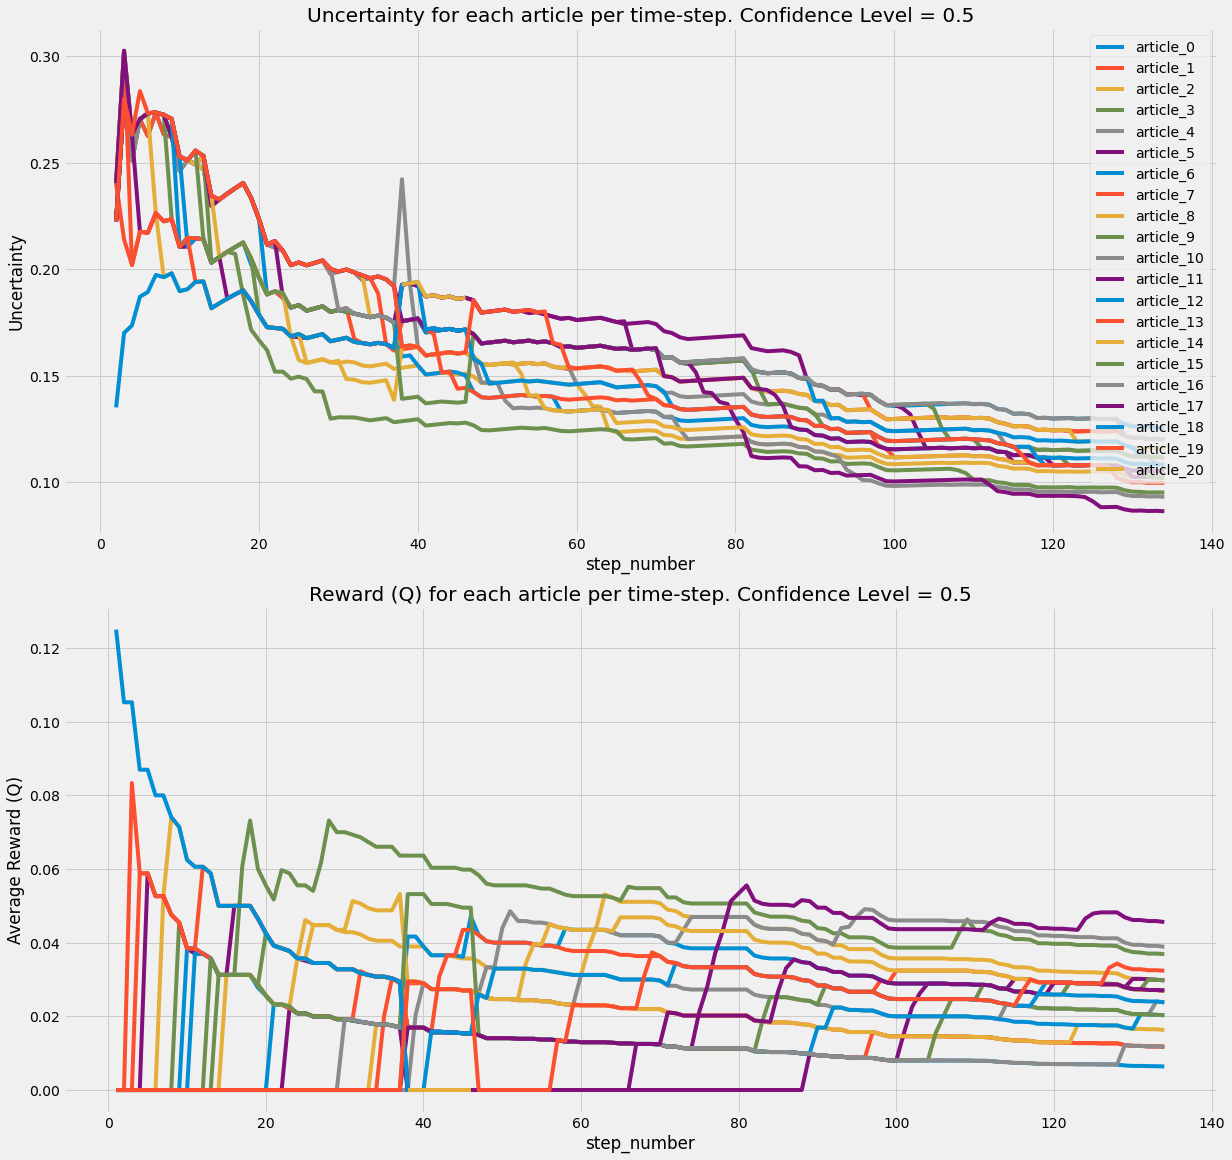

In [579]:
plot_ucb_confidence_level(0.5)

UCB1 (α=10)         0.0426    1.9s


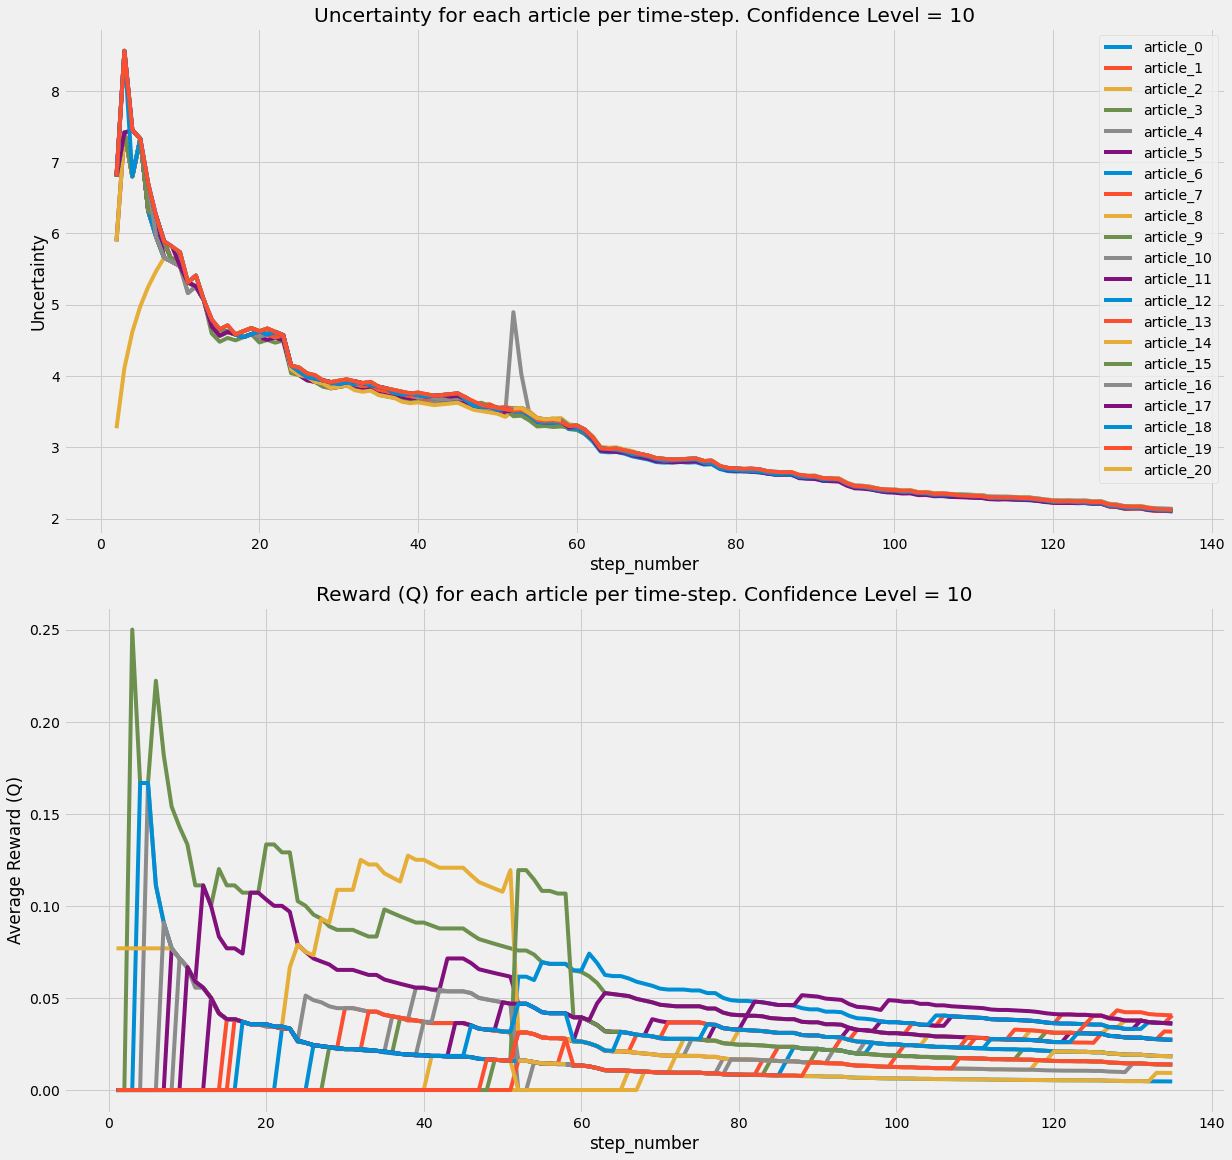

In [580]:
plot_ucb_confidence_level(10)

UCB1 (α=100)        0.0323    2.0s


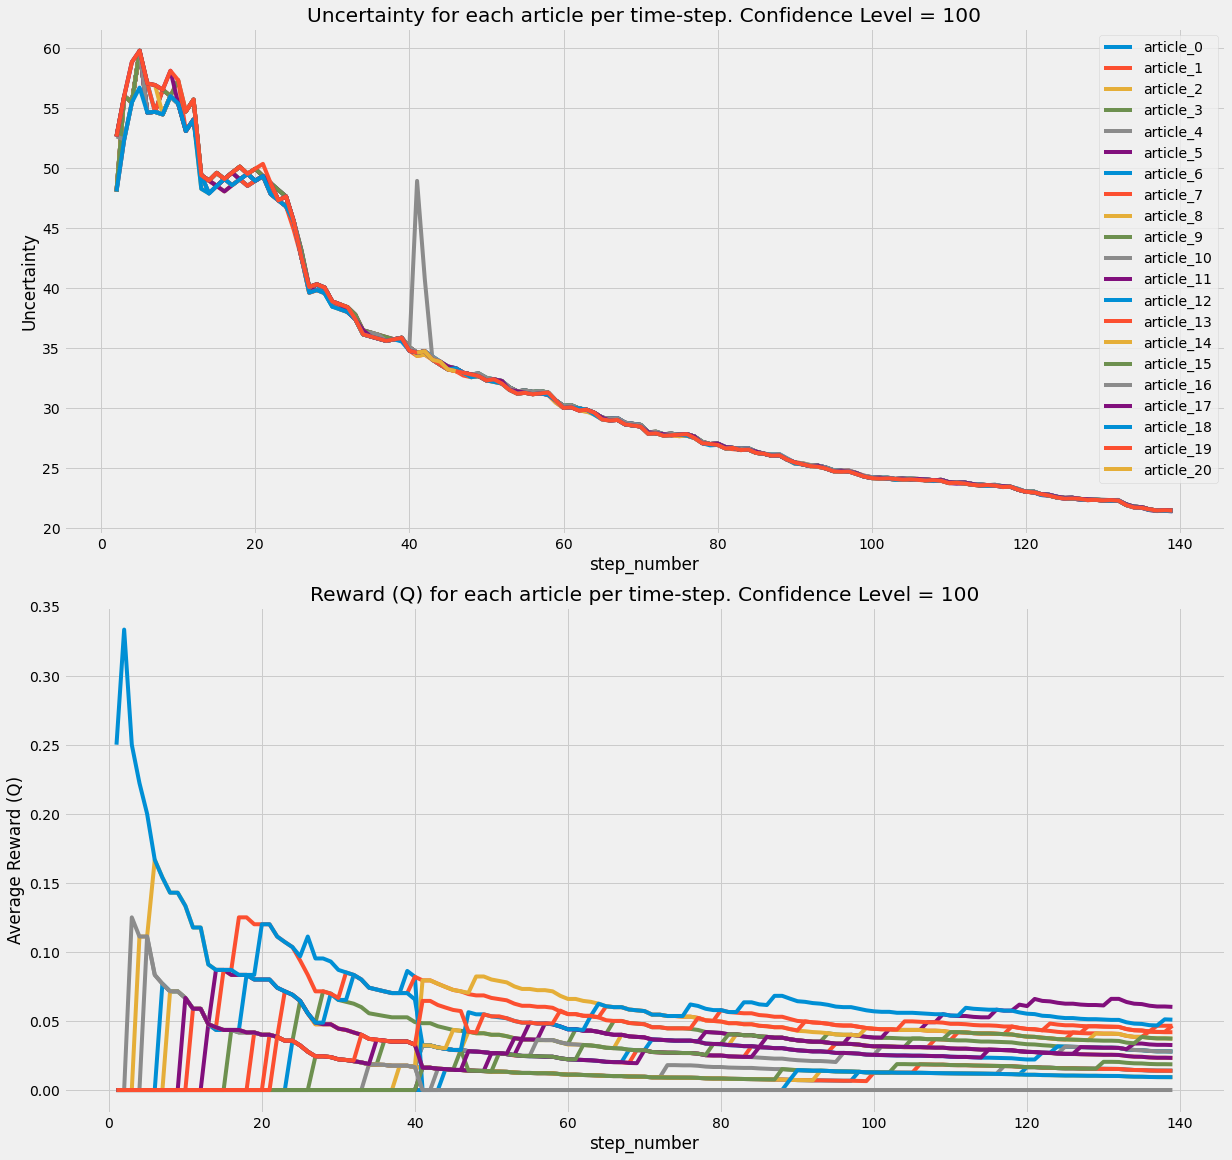

In [581]:
plot_ucb_confidence_level(100)

### Comparison between UCB and Epsilon Greedy:

It looks like UCB can achieve similar and better results than Epsilon-greedy in fewer steps. Since we are exploring articles that don't have enough data (and therefore have higher uncertainty) first, we are able to be more efficient with UCB. 

## Thompson Sampling

In [513]:
class ThompsonSampling:
    """ Implement a Bernoulli Thompson Sampler. Source: https://towardsdatascience.com/thompson-sampling-fc28817eacb8
    """
    def __init__(self):
        """
        Parameters
        ----------
        """
        
        ### Our prior beta distributions will be uniform (alpha=1, beta=1)
        self.alpha = np.ones(n_arms)
        self.beta = np.ones(n_arms)
        self.algorithm = 'Thompson Sampling'

    def choose_arm(self, t, user, pool_idx):
        """
        Returns the best arm's index relative to the pool
        Parameters
        ----------
        t : number (number of trial)
        user : array (user features)
        pool_idx : array of indexes (pool indexes for article identification)
        """
        
        ### Sample from our beta distributions.
        
        return np.argmax(np.random.beta(self.alpha[pool_idx], self.beta[pool_idx]))

    def update(self, displayed, reward, user, pool_idx):
        """
        Updates algorithm's parameters(matrices)
        Parameters
        ----------
        displayed : index (displayed article index relative to the pool)
        reward : binary (user clicked or not)
        user : array (user features)
        pool_idx : array of indexes (pool indexes for article identification)
        """

        a = pool_idx[displayed]
        
        
        # Update our beta distributions. 
        self.alpha[a] += reward
        self.beta[a] += (1 - reward)




In [517]:
thompson = ThompsonSampling()
a, deploy = evaluate(thompson)

Thompson Sampling   0.0508    2.4s


### Comparison between UCB and Thompson Sampling

Thompson Sampling performed better than any other Contextual Bandit Algorithm even though I used a really simple implementation of Thompson Sampling. Each article begins with a uniform prior distribution (beta-distribution with alpha=0 and beta=0). As we get more information, we update each article's beta and alpha. Articles with fewer data will have wider and beta distributions which suggests that we have more uncertainty about that article. 